# Transformers desde (casi) cero

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%203%20-%20Transformers/transformers-from-scratch.ipynb)

En este notebook implementaremos un clasificador de noticias en español utilizando transformers. Implementaremos parte de la arquitectura del modelo pieza por pieza para ver como funciona por dentro. Sin embargo, utilizarémos las utilidades de tokenización de huggingface transformers para ayudarnos con esta tarea.

#### Referencias
- Dataset: https://huggingface.co/datasets/MarcOrfilaCarreras/spanish-news
- [Attention is All You Need](http://arxiv.org/abs/1706.03762)
- [Natural Language Processing with Transformers: Building Language Applications With Hugging Face](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246)

In [48]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [49]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%203%20-%20Transformers/requirements.txt && pip install -r requirements.txt

### Cargando el dataset
Este es un dataset pequeño de articulos de noticias en idioma español con sus respectivas categorías. El dataset está disponible en el HuggingFace Hub y puede ser fácilmente descargado con la librería.

In [47]:
from datasets import load_dataset
import warnings
import os

warnings.filterwarnings("ignore")
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
dataset = load_dataset('MarcOrfilaCarreras/spanish-news', split='train')
dataset

Dataset({
    features: ['language', 'category', 'newspaper', 'hash', 'text'],
    num_rows: 10200
})

Observemos uno de sus registros...

In [2]:
dataset[0]

{'language': 'es',
 'category': 'play',
 'newspaper': 'de_lector_a_lector',
 'hash': '1bcca6442ad224ca731b6e99b018ac219116e34c',
 'text': 'Valladolid misteriosa es el título del nuevo libro que acaba de publicar la editorial Almuzara. Se trata de una obra del investigador de lo paranormal, Juan Carlos Pasalodos Pérez, quien realiza una exhaustiva recopilación de gran parte de los enigmas y relatos legendarios vinculados a la historia de Valladolid.Y es que esta capital se caracteriza por su rica historia y, por ende, por su abundancia de leyendas y arcanos, que el autor recoge en este volumen junto con una serie de casos asombrosos ocurridos tanto en la misma urbe como en la provincia, relacionados con fenómenos inexplicables que parecen esquivos a la comprensión humana.Así, entre las páginas de este libro, podremos encontrar relatos de lo paranormal, coincidencias inverosímiles, testimonios sorprendentes, avistamientos, exorcismos, sucesos que desafían toda explicación lógica, y miste

Para los efectos de esta tarea, nos servirán el texto y la categoría naturalmente.

A manera general, observemos que tan largos o cortos tienden a ser los textos.

In [50]:
text_lengths = [len(row['text']) for row in dataset]
print(f"Texto más corto: {min(text_lengths)}")
print(f"Texto más largo: {max(text_lengths)}")
print(f"Longitud promedio: {sum(text_lengths) / len(text_lengths)}")

Texto más corto: 501
Texto más largo: 204324
Longitud promedio: 4218.154509803921


Estos valores son la cantidad de *caractéres* que tiene las secuencias. Una decisión ingenua pero útil en este momento podría ser ajustar la longitud de las secuencias que vamos a usar para el entrenamiento a unos 2000 tokens. Esto podría ser suficiente para capturar una porción significativa de los textos.

## Definiendo el Tokenizer

Ahora, vamos a definir el tokenizer para nuestra tarea. Para ahorrarnos tiempo, vamos a entrenar uno basado en gpt2, pero ajustandolo a nuestro dataset. Para ello, debemos seleccionar una muestra representativa de nuestro dataset, como no es muy grande, casi que podemos usarlo todo. Luego, debemos definir el tamaño del vocabulario, es decir, cuantos tokens únicos queremos soportar en nuestro tokenizador. Para que un modelo de lenguaje funcione moderadamente bien para una tarea de clasificación, considerando el tamaño de nuestro corpus, deberíamos definir unos 50 mil tokens.

In [4]:
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode


length = 10000
iter_dataset = iter(dataset)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

def batch_iterator(batch_size: int = 10):
    for _ in tqdm(range(0, length, batch_size)):
        yield [next(iter_dataset)['text'] for _ in range(batch_size)]

spanish_news_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=50000, initial_alphabet=base_vocab)


100%|██████████| 1000/1000 [00:10<00:00, 95.34it/s]


Exploremos ahora el tokenizador obtenido.

In [5]:
tokens = sorted(spanish_news_tokenizer.vocab.items(), key=lambda x: x[1], reverse=False)
print(f"Vocabulario: {spanish_news_tokenizer.vocab_size} tokens")
print("Primeros 15 tokens:")
print([f"{spanish_news_tokenizer.convert_tokens_to_string([t])}" for t, _ in tokens[:15]])
print("15 tokens de en medio:")
print([f"{spanish_news_tokenizer.convert_tokens_to_string([t])}" for t, _ in tokens[1000:1015]])
print("Últimos 15 tokens:")
print([f"{spanish_news_tokenizer.convert_tokens_to_string([t])}" for t, _ in tokens[-15:]])

Vocabulario: 50000 tokens
Primeros 15 tokens:
['<|endoftext|>', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.']
15 tokens de en medio:
['pul', 'ece', ' Car', ' op', ' hech', 'ome', ' Ar', ' cen', 'ensa', 'ismo', 'ós', 'ord', 'at', '”.', 'lec']
Últimos 15 tokens:
['yang', 'zidina', 'zambique', '\x96', ' ud', ' �', 'deado', ' each', ' eches', ' eternidad', ' eferentes', ' eBook', ' deple', ' dedu', ' deduce']


Vemos que los primeros tokens corresponden a caracteres especiales y puntiación. Luego en el medio tenemos una combinación entre palabras completas y cortadas, el tokenizador se encarga de encontrar las frecuencias más comunes y asi partir las palabras por aquellas partes que tienden a repetirse mas. Esto es muy útil para trabajar con modelos de lenguaje ya que el modelo se vuelve robusto a diferentes ramificaciones de palabras e incluso a errores de tipografía. Finalmente, al final, vemos que tenemos más palabras cortadas y palabras muy especiales. Algo importante aquí es que podamos ver que los tokens tienen sentido con respecto a nuestro corpus.

Ahora veamos como convierte el tokenizador una oración muy sencilla:

In [6]:
spanish_news_tokenizer.pad_token = '[PAD]'
spanish_news_tokenizer("hola mundo!", max_length=8, truncation=True, padding='max_length')

{'input_ids': [72, 1086, 1039, 1, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0]}

Lo que obtenemos de vuelta son los ids de cada token según el vocabulario. Ahora algo importante que notamos aquí es el *padding*, durante el entrenamiento, queremos que las secuencias sean de tamaño fijo, para asi operar comodamente con matrices. Pero ya vimos que no todos los textos tienen la misma longitud. Entonces que hacer? para los que son más largos que una longitud dada simplemente cortamos, pero para los que son más cortos, debemos *rellenar* lo faltante con un *token especial de relleno o padding*. Y es justo lo que definimos allí, cuando la cadena es inferior a 8 **tokens**, entonces debemos hacer padding hasta que se cumplan los 8.

Ahora, notemos que "hola mundo!" son 2 palabras, 9 letras, 1 espacio y 1 simbolo para un total de 11 caracteres, pero vemos que el resultado son 4 tokens y el padding. Esto es trabajo del tokenizador. Cuando lo entrenamos con nuestro corpus, el tokenizador computó las frecuencias de palabras y sus partes, tal como vimos arriba, entonces, estos tokens juntos forman la frase original, observemos:

In [51]:
spanish_news_tokenizer("hola mundo!", max_length=8, truncation=True, padding='max_length').tokens()

['h', 'ola', 'Ġmundo', '!', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Claramente vemos los 4 tokens como cadenas independientes.

### Definiendo el dataset de pytorch
Ahora podemos proceder a definir el dataset. Esto debería ser muy sencillo dado que nuestro dataset es pequeño y ya tenemos el tokenizador listo.

In [7]:
import torch
import numpy as np
from typing import Tuple, Dict
from torch.utils.data import Dataset

class SpanishNewsDataset(Dataset):

    def __init__(self, tokenizer, dataset, seq_length: int = 512):
        self.tokenizer = tokenizer
        self.tokenizer.pad_token = '[PAD]'
        self.dataset = dataset
        self.seq_length = seq_length
        # Definimos estos dos mapas para facilitarnos la tarea
        # de traducir de nombres de categoría a ids de categoría.
        self.id_2_class_map = dict(enumerate(np.unique(dataset[:]['category'])))
        self.class_2_id_map = {v: k for k, v in self.id_2_class_map.items()}
        self.num_classes = len(self.id_2_class_map)

    def __getitem__(self, index) -> Dict[str, torch.Tensor]:
        text, y = self.dataset[index]['text'], self.dataset[index]['category']
        y = self.class_2_id_map[y]
        data = {k: torch.tensor(v) for k, v in self.tokenizer(text, max_length=self.seq_length, truncation=True, padding='max_length').items()}
        data['y'] = torch.tensor(y)
        return data


    def __len__(self):
        return len(self.dataset)

Ahora instanciaremos el dataset entero. Para este experimento, definiremos un tamaño máximo de secuencia de 2048 **tokens**. Que según nuestra intuición arriba, debería ser suficiente para la tarea.

In [8]:
max_len = 2048 
spanish_news_dataset = SpanishNewsDataset(spanish_news_tokenizer, dataset, seq_length=max_len)
assert len(spanish_news_dataset) == len(dataset)

Y luego, procedemos a hacer el train-val-test split y crear los dataloaders.

In [9]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 4 if not IN_COLAB else 12
train_dataset, val_dataset, test_dataset = random_split(spanish_news_dataset, lengths=[0.8, 0.1, 0.1])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

### Definición de los Positional Embeddings

Según el paper, los autores agregan una secuencia sinusoidal a los embeddings de los tokens con el fin de inyectar información referente a la posición de cada token en las frases. Esto obedece a la definición:

$$
PE(pos, 2i) = \sin(pos/10000^{2i/d_{model}}) \\
PE(pos, 2i + 1) = \cos(pos/10000^{2i/d_{model}})
$$

Donde: 
- $pos$ es la posición del *token* en la secuencia.
- $i$ es la dimensión $i$ en el embedding $d$.
- $d_model$ es la dimensionalidad total del embedding.

Lo que los autores propusieron fue que para las posiciones pares, se calculara el seno de la posición, relativa a la dimensionalidad del embedding y para las posiciones impares, se calculara el coseno. Según los autores, estos tenían la hipótesis de que estas funciones inyectarían la información posicional relativa de forma eficiente, en parte porque se pueden pre-calcular e inyectar directamente durante el entrenamiento, evitando asi emplear recursos en entrenar estructuras para aprenderlos.

Esto último es particularmente importante ya que se evita tanto hacer uso de recursos innecesarios como acelerar el proceso de entrenamiento al no tener que computar gradientes para esta parte. Sin embargo, los autores también mencionaron que es ciertamente posible aprender estos positional embeddings como parte del entrenamiento y que según sus resultados, no había mucha diferencia entre ambos enfoques, razón por la cual, se prefiere el positional encoding sinusoidal.

In [10]:
import numpy as np
import torch.nn as nn
from enum import Enum
from typing import Optional


class PosEncodingType(Enum):
    SINUSOID = 1
    LEARNABLE = 2


class SinusoidPE(nn.Module):

    def __init__(self, max_len: int, d_model: int):
        super(SinusoidPE, self).__init__()
        
        # Definimos un vector columna con las posiciones de la secuencia de entrada (pos)
        pos = torch.arange(max_len).unsqueeze(1)
        # Definimos un vector de fila con las dimensiones del embedding (i)
        i = torch.arange(d_model).unsqueeze(0)

        # Calculamos el denominador segun la formula
        div_term = 1 / torch.pow(10000, (2 * (i // 2)) / torch.tensor(d_model, dtype=torch.float32))
        # Aplicamos el denominador a las posiciones
        angle_rads = pos * div_term

        # Inicializamos la matriz de positional encodings
        pos_encoding = torch.zeros(max_len, d_model)
        # Calculamos los embeddings para los numeros pares con seno: PE(pos, 2i)
        pos_encoding[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        # Calculamos los embdeddings para los numeros inpares con coseno: PE(pos, 2i+1)
        pos_encoding[:, 1::2] = torch.cos(angle_rads[:, 1::2])
        
        # Registramos la variable como atributo de clase
        self.register_buffer("pos_encoding", pos_encoding.unsqueeze(0), persistent=False)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pos_encoding[:, :x.size(1), :]
    

class LearnablePE(nn.Module):

    def __init__(self, vocab_size: int, d_model: int, max_len: int = float('-inf')):
        super(LearnablePE, self).__init__()
        self.max_len = max_len
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        positions = torch.arange(0, max(x.size(-1), self.max_len))
        pos_emb = self.embedding(positions)
        return x + pos_emb



class TokenAndPosEmbedding(nn.Module):

    def __init__(self, max_len: int, embed_dim: int, vocab_size: int, pos_encoding_type: PosEncodingType = PosEncodingType.SINUSOID):
        super(TokenAndPosEmbedding, self).__init__()
        self.token_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        if pos_encoding_type == PosEncodingType.SINUSOID:
            self.pos_emb = SinusoidPE(max_len, embed_dim)
        else:
            self.pos_emb = LearnablePE(vocab_size, embed_dim)


    def forward(self, x):
        token_emb = self.token_emb(x)
        return self.pos_emb(token_emb)

        

Ahora procedemos a instanciar el modulo que va a convertir los tokens en embeddings con positional embeddings.

In [11]:
emb_dim = 128 if not IN_COLAB else 256
tpe = TokenAndPosEmbedding(max_len, emb_dim, spanish_news_tokenizer.vocab_size)
pos_encoding = tpe.pos_emb.pos_encoding.squeeze(0).numpy()


A manera exploratoria, podemos observar gráficamente en que consisten estos vectores. En el siguiente gráfico podemos observar como los valores tienden a oscilar para diferentes posiciones en la dimensionalidad del embedding. Los valores individuales no tienen una interpretación directa, pero lo que vale la pena resaltar es que se observa una "transición" a medida que nos desplazamos por las dimensiones del embedding y sus respectivas posiciones, no es solo ruido.

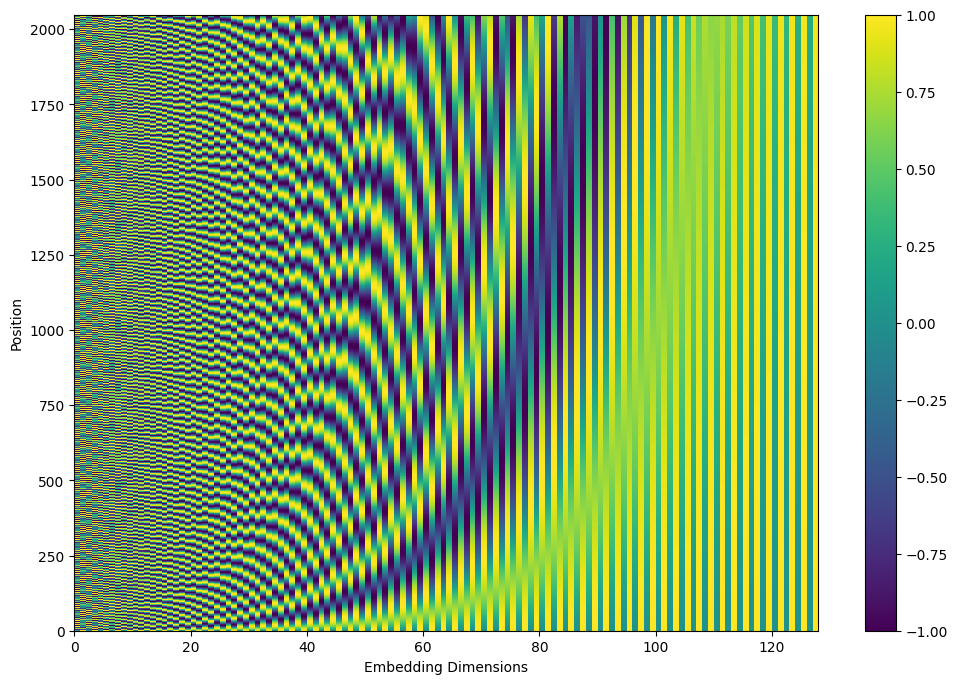

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.pcolormesh(pos_encoding, cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, emb_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Ahora, si pasamos nuestra frase simple por el tokenizador, deberíamos obtener una matriz con la forma: $(longitud, d_{model})$:

In [13]:
text = "hola mundo!"
tokens = spanish_news_tokenizer(text, max_length=max_len, truncation=True, padding='max_length')
x = torch.tensor(tokens['input_ids']).unsqueeze(0)
mask = torch.tensor(tokens['input_ids']).unsqueeze(0)
embedding = tpe(x)
embedding.shape

torch.Size([1, 2048, 128])

### Multi-Head Attention

![](../assets/mh-attention.png)

Ahora procedemos a definir al núcleo del modelo. Recodemos que la atención se define por:

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_K}})V
$$

Que es la definición de "Scaled Dot-Product Attention". Y Multi-Head Attention es la concatenación de varias cabezas ejecutando el mismo scaled dot-product sobre partes del input. Entonces tenemos:

In [14]:
import math


class MultiHeadAttention(nn.Module):

    def __init__(self, embed_size: int, num_heads: int = 8):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        assert embed_size & num_heads == 0, 'El tamaño del embedding debería ser divisible por el numero de cabezas'
        self.projection_dim = embed_size // num_heads
        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.value = nn.Linear(emb_dim, emb_dim)
        self.comibe_heads = nn.Linear(emb_dim, emb_dim)


    @staticmethod
    def _scaled_dot_product(q, k, v, mask=None):
        """scaled dot product.

        Esta función define el bloque mencionado.
        Aquí se hace la multiplicación de matrices
        entre los Q, K y V para luego calcular el 
        score de atención.

        Nótese además que aquí aplicamos una máscara
        de atención. Esto se debe a que como estamos
        rellenando las cadenas cortas con un token que
        en si mismo no trae ningún significado, no queremos
        que la red desperdicie recursos operando sobre este
        token, entonces usamos la máscara para poner los valores
        de atención en numeros muy pequeños para que al
        calcular el score, estos no sobresalgan sobre los demás.
        """
        # d_k para el escalamiento
        d_k = q.size()[-1]

        # multiplicacion Q \cdot K^T 
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        # escalamiento
        attn_logits = attn_logits / math.sqrt(d_k)
        
        # Se aplica la máscara
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask.reshape(mask.shape[0], 1, 1, -1) == 0, -9e-15)

        # Se calcula el score de atención.
        attention = torch.softmax(attn_logits, dim=-1)
        # Se obtienen los valores tras el score de atención.
        values = torch.matmul(attention, v)
        return values, attention
    

    def _separate_heads(self, x, batch_size):
        # Llega: (batch, seq_len, emb_dim)
        x =  x.reshape(batch_size, -1, self.num_heads, self.projection_dim)  # (batch, seq_len, num_heads, emb_dim / num_heads)
        return x.permute(0, 2, 1, 3)  # (batch, num_heads, seq_len, emb_dim / num_heads)
    

    def forward(self, x, mask=None, return_attention=False):
        """forward

        Este es todo el forward pass del multi-head attention.
        Aquí se coordina el resto de las operaciones, como
        la concatenación de las múltiples cabezas como 
        el paso por la capa densa previo a entregar el
        resultado.
        """
        # x: (batch, seq_len, emb_dim)
        batch_size, seq_len, emb_dim = x.size()
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = self._separate_heads(q, batch_size)
        k = self._separate_heads(k, batch_size)
        v = self._separate_heads(v, batch_size)

        weights, attention = self._scaled_dot_product(q, k, v, mask)
        weights = weights.permute(0, 2, 1, 3) # (batch, seq_len, num_heads, emb_dim / num_heads)
        weights = weights.reshape(batch_size, seq_len, emb_dim)
        output = self.comibe_heads(weights)
        
        if return_attention:
            return output, attention
        else:
            return output


Podemos hacer una prueba rápida de que las operaciones funcionan a nivel de matrices.

In [15]:
mha = MultiHeadAttention(emb_dim)
mha(embedding, mask).shape

torch.Size([1, 2048, 128])

### Definición del bloque transformers

![](../assets/transformers-achitecture.png)

Finalmente, definimos el bloque de transformers. Recordemos que como esta es una tarea de clasificación, solamente necesitamos el encoder, por lo que esto es silamente la primera parte del diseño de arquitecura de red.

En esta capa, simplemente ponemos una capa densa adicional junto con las normalizaciones a nivel de capa.

In [16]:
class TransformerBlock(nn.Module):

    def __init__(self, emb_dim: int, num_heads: int = 8):
        super(TransformerBlock, self).__init__()
        self.mhatt = MultiHeadAttention(emb_dim, num_heads)
        self.mhatt_dropput = nn.Dropout(0.2)
        self.ffn = nn.Sequential(
            nn.Linear(emb_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, emb_dim)
        )
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)


    def forward(self, x, mask=None):
        attn_output = self.mhatt(x, mask)
        attn_output = self.mhatt_dropput(attn_output)
        attn_output = self.layer_norm1(attn_output)
        ffn_out = self.ffn(attn_output)
        return self.layer_norm2(ffn_out)


Nuevamente, probamos rapidamente para asegurarnos que las capas operan correctamente.

In [17]:
tb = TransformerBlock(emb_dim)
tb(embedding, mask).shape

torch.Size([1, 2048, 128])

In [18]:
num_heads = 8
vocab_size = spanish_news_tokenizer.vocab_size

token_embeddings = TokenAndPosEmbedding(max_len, emb_dim, vocab_size)
transformer = TransformerBlock(emb_dim, num_heads)
ff = nn.Sequential(
    nn.Flatten(),
    nn.Linear(max_len * emb_dim, spanish_news_dataset.num_classes)
)

In [19]:
it = iter(train_loader)
batch = next(it)
x, mask, y = batch['input_ids'], batch['attention_mask'], batch['y']

embeddings = token_embeddings(x)
assert embeddings.shape == (train_loader.batch_size, max_len, emb_dim)

attention = transformer(embeddings, mask)
attention.shape

torch.Size([4, 2048, 128])

In [20]:
pred = ff(attention)
pred.shape

torch.Size([4, 12])

### Definición del clasificador

Finalmente, definimos el modelo en si. Este modelo constará de 3 capas:

- La tokenización, tal como la definimos anteriormente.
- El transformer, que acabamos de decinir.
- Una capa densa adicional que servirá como clasificador de aquello que nos entregue la capa del transformer.

Como este es un LightningModule, aquí definiremos el resto de funciones utilitarias para el entrenamiento de la tarea.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy


class SpanishNewsClassifier(LightningModule):

    def __init__(self, max_len: int, vocab_size: int, num_classes: int, emb_dim: int, num_heads: int = 8):
        super(SpanishNewsClassifier, self).__init__()
        self.num_classes = num_classes

        self.token_embeddings = TokenAndPosEmbedding(max_len, emb_dim, vocab_size)
        self.transformer = TransformerBlock(emb_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(max_len * emb_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

        self.train_acc = Accuracy(task='multiclass', num_classes=num_classes)
        self.val_acc = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=num_classes)


    def forward(self, x, mask=None):
        embeddings = self.token_embeddings(x)
        attention = self.transformer(embeddings, mask)
        return self.classifier(attention)
    

    def training_step(self, batch):
        x, mask, y = batch['input_ids'], batch['attention_mask'], batch['y']
        y_hat = self(x, mask)
        loss = F.cross_entropy(y_hat, y)
        self.train_acc(y_hat, y)
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch):
        x, mask, y = batch['input_ids'], batch['attention_mask'], batch['y']
        y_hat = self(x, mask)
        loss = F.cross_entropy(y_hat, y)
        self.val_acc(y_hat, y)
        self.log('val-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch):
        x, mask, y = batch['input_ids'], batch['attention_mask'], batch['y']
        y_hat = self(x, mask)
        self.test_acc(y_hat, y)
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def predict_step(self, batch):
        x, mask = batch['input_ids'], batch['attention_mask']
        return self(x, mask)


    def configure_optimizers(self):
        optimizer =  torch.optim.AdamW(self.parameters(), lr=2e-5, weight_decay=1e-5)
        return optimizer
    

model = SpanishNewsClassifier(max_len=spanish_news_dataset.seq_length, vocab_size=spanish_news_tokenizer.vocab_size, num_classes=spanish_news_dataset.num_classes, emb_dim=emb_dim)

tb_logger = TensorBoardLogger('tb_logs', name='TransformersClassifier')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=10, devices=1, logger=tb_logger, callbacks=callbacks, precision="16-mixed")

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params
----------------------------------------------------------
0 | token_embeddings | TokenAndPosEmbedding | 6.4 M 
1 | transformer      | TransformerBlock     | 198 K 
2 | classifier       | Sequential           | 134 M 
3 | train_acc        | MulticlassAccuracy   | 0     
4 | val_acc          | MulticlassAccuracy   | 0     
5 | test_acc         | MulticlassAccuracy   | 0     
----------------------------------------------------------
140 M     Trainable params
0         Non-trainable params
140 M     Total params
563.804   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 2040/2040 [02:56<00:00, 11.53it/s, v_num=2, val-loss=2.900, val-acc=0.354, train-loss=2.280, train-acc=0.210]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2040/2040 [03:00<00:00, 11.32it/s, v_num=2, val-loss=2.900, val-acc=0.354, train-loss=2.280, train-acc=0.210]


Observemos el proceso de entrenamiento

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 95214), started 22:55:19 ago. (Use '!kill 95214' to kill it.)

Y como es de esperarse, realizaremos la validación contra el conjunto de prueba.

In [30]:
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 510/510 [00:07<00:00, 72.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.37254902720451355
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test-acc': 0.37254902720451355}]

### Haciendo predicciones

Finalmente, vamos a hacer uso del modelo y ver que tan bueno es para la clasificación de noticias.

In [36]:
predictions = trainer.predict(model, test_loader)
predictions = torch.cat(predictions, dim=0)
predictions = torch.argmax(predictions, dim=-1)
predictions = [spanish_news_dataset.id_2_class_map[pred] for pred in predictions.numpy()]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 510/510 [00:06<00:00, 81.75it/s]


In [52]:
import pandas as pd

test_indices = test_dataset.indices
df = pd.DataFrame(data={
    "texto": dataset[test_indices]['text'],
    "tokens": [spanish_news_tokenizer(v)['input_ids'] for v in dataset[test_indices]['text']],
    "categoría": dataset[test_indices]['category'],
    'predicción': predictions
}, index=test_indices)

df['tokens_string'] = df.tokens.apply(lambda t: spanish_news_tokenizer.convert_ids_to_tokens(t))
df = df[["texto", "tokens", "tokens_string", "categoría", "predicción"]]
df.style.set_table_styles(
    [
        {'selector': 'td', 'props': [('word-wrap', 'break-word')]}
    ]
)
df.head(15)

,texto,tokens,tokens_string,categoría,predicción
4197,A Carlos Alcaraz se le ve feliz en Buenos Aire...,"[33, 3652, 7890, 309, 540, 885, 9865, 279, 104...","[A, ĠCarlos, ĠAlcaraz, Ġse, Ġle, Ġve, Ġfeliz, ...",sport,sport
9627,El precio del alquiler es cada vez más elevado...,"[544, 1424, 323, 9736, 291, 889, 870, 383, 566...","[El, Ġprecio, Ġdel, Ġalquiler, Ġes, Ġcada, Ġve...",economy,sport
7683,El Mikve hallado en Venezuela es considerado ú...,"[544, 31700, 710, 33493, 279, 8169, 291, 7662,...","[El, ĠMik, ve, Ġhallado, Ġen, ĠVenezuela, Ġes,...",religion,politics
4515,Cada vez son más las novias que buscan una alt...,"[10183, 870, 558, 383, 337, 18456, 288, 6255, ...","[Cada, Ġvez, Ġson, ĠmÃ¡s, Ġlas, Ġnovias, Ġque,...",fashion,fashion
8123,"En aquel tiempo, dijo Jesús a sus discípulos:«...","[619, 1518, 903, 12, 2245, 2984, 264, 495, 163...","[En, Ġaquel, Ġtiempo, ,, Ġdijo, ĠJesÃºs, Ġa, Ġ...",religion,astronomy
1918,Impacto del proceso enseñanza-aprendizaje en l...,"[38997, 323, 1837, 13492, 13, 45753, 279, 280,...","[Impacto, Ġdel, Ġproceso, ĠenseÃ±anza, -, apre...",medicine,medicine
3176,La siguiente gráfica ilustra el momento del me...,"[606, 3202, 17964, 20898, 289, 1072, 323, 2103...","[La, Ġsiguiente, ĠgrÃ¡fica, Ġilustra, Ġel, Ġmo...",astronomy,politics
6543,Las elecciones autonómicas más reñidas en 15 a...,"[1492, 305, 34063, 10693, 383, 28033, 1252, 27...","[Las, Âł, elecciones, ĠautonÃ³micas, ĠmÃ¡s, Ġr...",politics,religion
4002,Islas Feroe acabó esta tarde ante Polonia su p...,"[15152, 585, 456, 475, 69, 6068, 494, 3469, 11...","[Is, las, ĠF, ero, e, ĠacabÃ³, Ġesta, Ġtarde, ...",sport,play
6621,Los Comuns han ofrecido a Jaume Asens ser su c...,"[1133, 17360, 647, 17620, 264, 31144, 26772, 4...","[Los, ĠComuns, Ġhan, Ġofrecido, Ġa, ĠJaume, ĠA...",politics,play


## Conclusiones
- Vemos que el modelo alcanza una tasa de correctitud alta lo cual nos indica que el modelo está cumpliendo bien su trabajo.
- Los transformers en su interior pueden ser un poco intimidantes pero los resultados que entregan son muy superiores a otros enfoques, clásicos.
- Los transformers son hambrientos de recursos, es necesario contar con hardware de alto calibre para poder acelerar el entrenamiento y a veces hast apoder acomodar el modelo en lo que se tenga disponible.